In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00


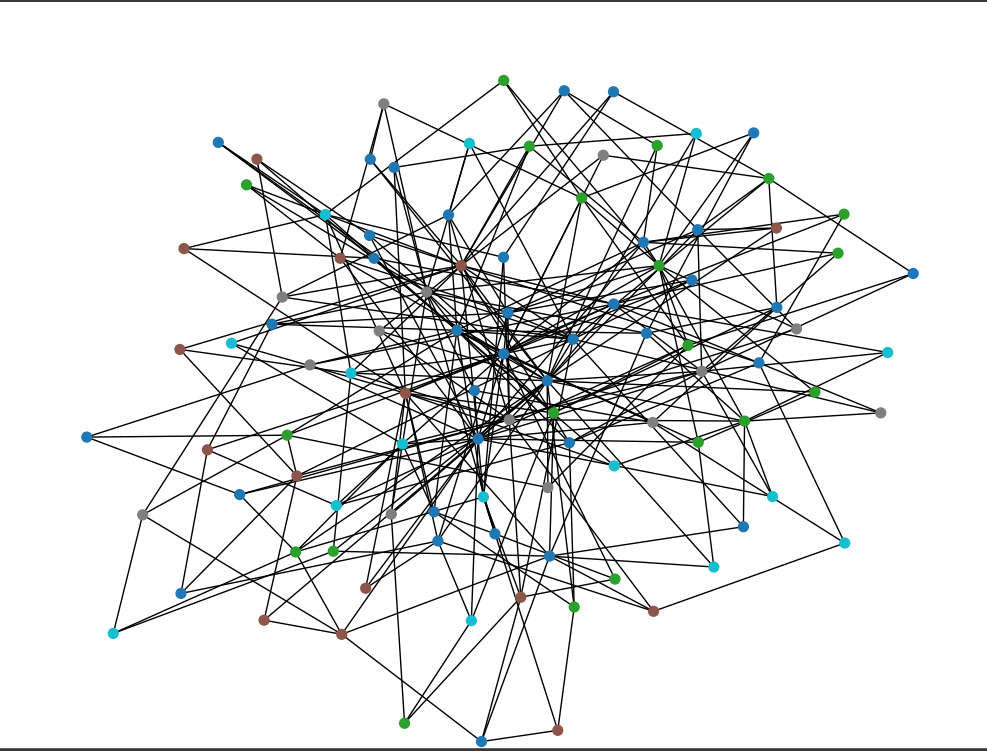

Epoch 000, Loss: 1.6118, Val Acc: 0.0667
Epoch 010, Loss: 1.0772, Val Acc: 0.2000
Epoch 020, Loss: 0.1597, Val Acc: 0.0667
Epoch 030, Loss: 0.0026, Val Acc: 0.0667
Epoch 040, Loss: 0.0002, Val Acc: 0.1333
Epoch 050, Loss: 0.0001, Val Acc: 0.1333
Epoch 060, Loss: 0.0000, Val Acc: 0.1333
Epoch 070, Loss: 0.0000, Val Acc: 0.1333
Epoch 080, Loss: 0.0000, Val Acc: 0.1333
Epoch 090, Loss: 0.0000, Val Acc: 0.1333


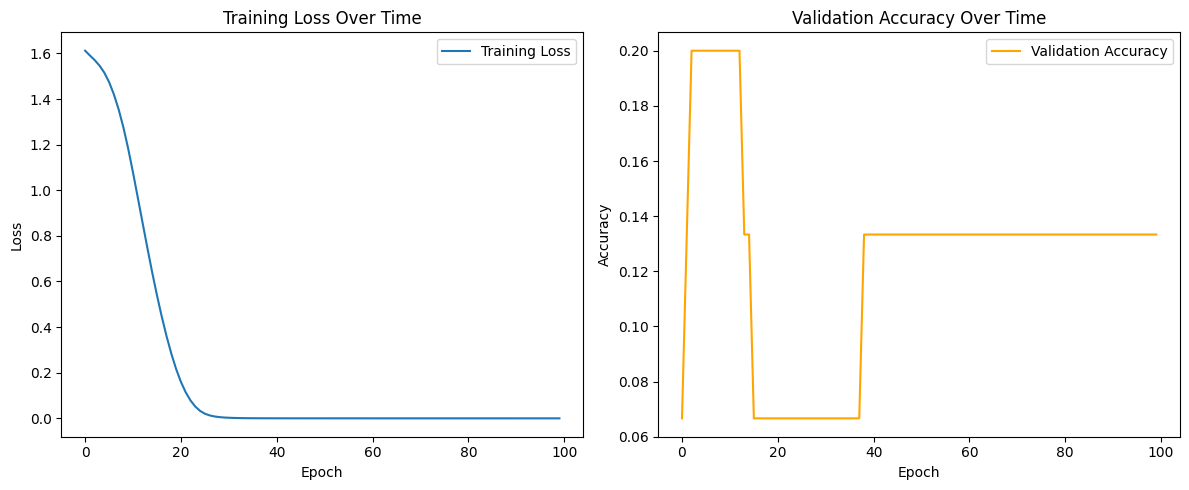

Test Accuracy: 0.2000


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch_geometric.utils import from_networkx

class AGCNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, init_adj=None):
        super(AGCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes = num_nodes

        # Инициализация адаптивной матрицы
        if init_adj is not None:
            self.adaptive_adj = nn.Parameter(torch.FloatTensor(init_adj))
        else:
            self.adaptive_adj = nn.Parameter(torch.rand(num_nodes, num_nodes))

        # Веса для преобразования признаков
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        with torch.no_grad():
            if hasattr(self, 'adaptive_adj'):
                self.adaptive_adj.data = self.adaptive_adj.data * 0.1

    def forward(self, x, static_adj=None):
        # Нормализация адаптивной матрицы
        adj = self.adaptive_adj
        adj = F.relu(adj)  # Обеспечиваем неотрицательность
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-12)  # Нормализация

        # Комбинация со статической матрицей (если предоставлена)
        if static_adj is not None:
            adj = adj + static_adj
            adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-12)

        # Преобразование признаков
        x_transformed = torch.matmul(x, self.weight)

        # Адаптивная свертка
        out = torch.matmul(adj, x_transformed)

        return F.relu(out)

class AGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_nodes, init_adj=None):
        super(AGCN, self).__init__()
        self.layer1 = AGCNLayer(num_features, hidden_dim, num_nodes, init_adj)
        self.layer2 = AGCNLayer(hidden_dim, hidden_dim, num_nodes)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, static_adj=None):
        x = self.layer1(x, static_adj)
        x = self.layer2(x, static_adj)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

def visualize_graph(adj_matrix, labels=None, title="Graph Structure"):
    G = nx.from_numpy_array(adj_matrix.detach().numpy())
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)

    if labels is not None:
        nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
                node_size=50, with_labels=False)
        plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                     label="Node Class")
    else:
        nx.draw(G, pos, node_size=50, with_labels=False)

    plt.title(title)
    plt.show()

def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Параметры
    num_nodes = 100
    num_features = 32
    hidden_dim = 64
    num_classes = 5
    epochs = 100
    lr = 0.01

    # Генерация данных
    G = nx.barabasi_albert_graph(num_nodes, 3)
    features = np.random.randn(num_nodes, num_features)
    labels = np.random.randint(0, num_classes, num_nodes)

    # Матрица смежности
    static_adj = torch.FloatTensor(nx.adjacency_matrix(G).toarray())

    # Визуализация исходного графа
   # visualize_graph(static_adj, labels, "Original Graph")

    # Преобразование данных
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    # Разделение данных
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    indices = torch.randperm(num_nodes)
    train_mask[indices[:int(0.7*num_nodes)]] = True
    val_mask[indices[int(0.7*num_nodes):int(0.85*num_nodes)]] = True
    test_mask[indices[int(0.85*num_nodes):]] = True

    # Модель и оптимизатор
    model = AGCN(num_features, hidden_dim, num_classes, num_nodes, static_adj)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(features, static_adj)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            pred = model(features, static_adj).argmax(dim=1)
            val_acc = accuracy_score(labels[val_mask].numpy(), pred[val_mask].numpy())
            val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

            # Визуализация адаптивной матрицы
            if epoch == 0 or epoch == epochs//2 or epoch == epochs-1:
                adj = model.layer1.adaptive_adj.detach()
                adj = F.relu(adj)
            #    visualize_graph(adj, title=f"Adaptive Adjacency at Epoch {epoch}")

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(features, static_adj).argmax(dim=1)
        test_acc = accuracy_score(labels[test_mask].numpy(), pred[test_mask].numpy())
        print(f'Test Accuracy: {test_acc:.4f}')

    # Визуализация предсказаний
  #  visualize_graph(static_adj, pred.numpy(), "Predicted Classes")

if __name__ == '__main__':
    main()